# Week-2 Assignment: Environment Design & Validation (RL)

This notebook focuses **only on environment design**, not training agents.

## Task 0: Imports & Seeding

In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

# TODO: Do not modify this cell

## Task 1: Implement the Environment (MDP)

In [36]:
class FlappyEnv:
    def __init__(self, gravity = 1.0):
        """
        TODO:
        - Initialize all environment constants
        - Store gravity
        - Do NOT use any RL library
        """
        self.width  = 900
        self.height = 600 
        self.bird_x = 150 # x-dimension offset ( Always fixed )
        self.gravity = gravity
        self.flap_velocity  = -12.0
        self.max_fall_speed = 15.0 # Can be helpful later  
        self.pipe_speed = 5
        self.pipe_gap = 150 # vertical distance 
        self.pipe_width = 80 # width of each pipe 
        self.pipe_spacing = 300 # (horizontal gap) Constant gap between pipe is good to limit computations for predicting next state
        self.reset()

    def reset(self):
        """
        TODO:
        - Reset bird position and velocity
        - Reset pipe position and gap location
        - Set done = False
        - Return initial state
        """
        self.bird_y = self.height // 2 # y-coordinate 
        self.bird_velocity = 0.0 # velocity 

        # Create multiple pipes
        self.pipes = [] # kinda like a circular queue of pipes 
        x = self.width # initialized at =(self.width + distance) and slowly slowly come towards flappy bird  
        for i in range(3): 
            gap_y = random.randint(self.pipe_gap // 2 , self.height - self.pipe_gap // 2) # [75 to h-75] random values  
            self.pipes.append([x, gap_y,False]) # passed = False
            # x is middle x-coordinate of pipe and gap_y is middle y-coordinate of gap
            x += self.pipe_spacing # horizontal coordinates 

        self.done = False
        return self._get_state()

    def _get_next_pipe(self):
        for pipe in self.pipes:
            if pipe[0] + self.pipe_width > self.bird_x:
                return pipe
        return self.pipes[0]

    def _get_state(self):
        """
        TODO:
        - State must be:
          (bird_y, bird_velocity, distance_to_pipe, gap_offset)
        - Return as numpy array
        """
        pipe_x, gap_y, _ = self._get_next_pipe()
        return np.array([self.bird_y, self.bird_velocity, pipe_x - self.bird_x, gap_y])

    def step(self, action):
        """
        action ∈ {0, 1}
        0 -> do nothing
        1 -> flap
        TODO:
        - Apply physics
        - Update positions
        - Check collisions
        - Compute reward
        - Return (next_state, reward, done)
        """
        if self.done:
            return self._get_state(), 0, True

        if action == 1:
            self.bird_velocity = self.flap_velocity

        self.bird_velocity += self.gravity
        self.bird_velocity = min(self.bird_velocity, self.max_fall_speed)
        self.bird_y += self.bird_velocity

        for pipe in self.pipes:
            pipe[0] -= self.pipe_speed

        reward = 1  # alive reward

        for pipe in self.pipes:
            pipe_x, gap_y, passed = pipe
            if not passed and pipe_x + self.pipe_width / 2 < self.bird_x:
                pipe[2] = True
                reward += 10  

        if self.pipes[0][0] < -self.pipe_width:
            self.pipes.pop(0)
            new_x = self.pipes[-1][0] + self.pipe_spacing
            new_gap = random.randint(self.pipe_gap/2, self.height - self.pipe_gap/2)
            self.pipes.append([new_x, new_gap, False])

        if self.bird_y <= 0 or self.bird_y >= self.height:
            reward = -100 
            self.done = True

        pipe_x, gap_y, _ = self._get_next_pipe()
        if abs(pipe_x - self.bird_x) < self.pipe_width / 2:
            if abs(self.bird_y - gap_y) > self.pipe_gap / 2:
                reward = -100  
                self.done = True

        # Later I can reward it a bit if it stays at the middle of screen i.e. | height/2 - y | < epsilon  
        # and also penalise if it goes away from goal  

        return self._get_state(), reward, self.done


## Task 2: Markov Property Validation

In [17]:
def is_markov_sufficient(env, state, action=0, trials=10):
    """
    TODO:
    - Reset environment multiple times
    - Force the same state
    - Take the same action
    - If next states differ → return False
    - Else return True
    """
    next_states = []
    for _ in range(trials) :
        env.reset()
 
        env.bird_y = state[0]
        env.bird_velocity = state[1]
        pipe_x = env.bird_x + state[2] 
        gap_y = state[3] # 75 <= val <= h-75
        env.pipes[0][0] = pipe_x
        env.pipes[0][1] = gap_y

        next_state, reward, done = env.step(action)    
        next_states.append((next_state, reward, done))
 
    ref_state, ref_reward, ref_done = next_states[0]
    for s, r, d in next_states[1:]:
        if not np.array_equal(s, ref_state):
            return False
        if r != ref_reward or d != ref_done:
            return False

    return True

## Task 3: Discretization

In [18]:
def discretize_state(state):
    """
    TODO:
    Discretize state using:
    - bird_y / gap_offset: below, inside, above
    - velocity: falling fast, slow, rising
    - distance_to_pipe: near, far
    Return a tuple of discrete values
    """
    bird_y, bird_vel, dist_to_pipe, gap_y = state
    delta_y = bird_y - gap_y

    # Gotta check all these collision equalities also

    if delta_y < - 150 / 2:
        pos = "below" # Later I can encode them as numerical data 
    elif delta_y > 150 / 2:
        pos = "above"
    else:
        pos = "inside"

    if bird_vel < -5.0:
        vel = "rising"
    elif bird_vel > 5.0:
        vel = "falling_fast"
    else:
        vel = "slow"

    if dist_to_pipe < 150:
        dist = "near"
    else:
        dist = "far"

    return (pos, vel, dist)


## Task 4: Discrete State Space Size

In [19]:
# TODO:
# - Define number of bins per dimension
# - Compute total discrete states
# - Assert total_states <= 10000

bins_pos = 3
bins_vel = 3
bins_dist = 2
total_states = bins_pos * bins_vel * bins_dist
assert total_states <= 10_000

## Task 5: Reward Functions

In [ ]:
def sparse_reward(info):
    """
    TODO:
    - +10 for passing pipe
    - -50 for death
    - 0 otherwise
    """
    if info["dead"]:
        return -50
    elif info["passing_pipe"]:
        return 10 
    else:  
        return 0

def dense_reward(info):
    """
    TODO:
    - Small positive reward for staying alive
    - Large negative reward for death
    """
    if info["dead"]:
        return -100
    else:
        return 0.1

def shaped_reward(info):
    """
    TODO:
    - Start from dense reward
    - Penalize distance from gap center slightly
    - Shaping must not dominate sparse reward
    """
    if info["dead"]:
        return -100
    reward = 0.1
    penalty = 0.1 * abs(info["bird_y"]-info["gap_y"]) / info["height"] # order -2 to -1 (doesn't dominate sparse reward)  
    return reward - penalty

## Task 6: Random Policy Validation

In [40]:
def run_random_policy(env, episodes=500):
    """
    TODO:
    - Run random actions
    - Track episode lengths & rewards
    - Print statistics
    - Warn if environment is too easy or too hard
    """
    episode_lengths = []
    episode_rewards = []

    for _ in range(episodes):
        env.reset()
        total_reward = 0
        length = 0

        while not env.done:
            action = random.choice([0, 1]) 
            __ , reward, _ = env.step(action)
            total_reward += reward
            length += 1

        episode_lengths.append(length)
        episode_rewards.append(total_reward)

    avg_length = np.mean(episode_lengths)
    avg_reward = np.mean(episode_rewards)
    min_length = min(episode_lengths)
    max_length = max(episode_lengths)
    std_length = np.std(episode_lengths)
    std_reward = np.std(episode_rewards)

    print(f"Average Episode Length: {avg_length:.2f} ± {std_length:.2f}")
    print(f"Min episode length: {min_length}")
    print(f"Max episode length: {max_length}")
    print(f"Average Episode Reward: {avg_reward:.2f} ± {std_reward:.2f}")

    if avg_length > 100:
        print("Environment too easy\n")
    elif avg_length < 10:
        print("Environment too hard\n")
    else:
        print("Environment difficulty looks reasonable\n")

    return avg_length

## Task 7: Environment Stress Testing

Gravity == 0.8
Average Episode Length: 30.31 ± 1.91
Min episode length: 28
Max episode length: 39
Average Episode Reward: -70.69 ± 1.91
Environment difficulty looks reasonable

Gravity == 1.0
Average Episode Length: 31.38 ± 2.28
Min episode length: 28
Max episode length: 44
Average Episode Reward: -69.62 ± 2.28
Environment difficulty looks reasonable

Gravity == 1.2
Average Episode Length: 32.88 ± 2.76
Min episode length: 29
Max episode length: 54
Average Episode Reward: -68.12 ± 2.76
Environment difficulty looks reasonable



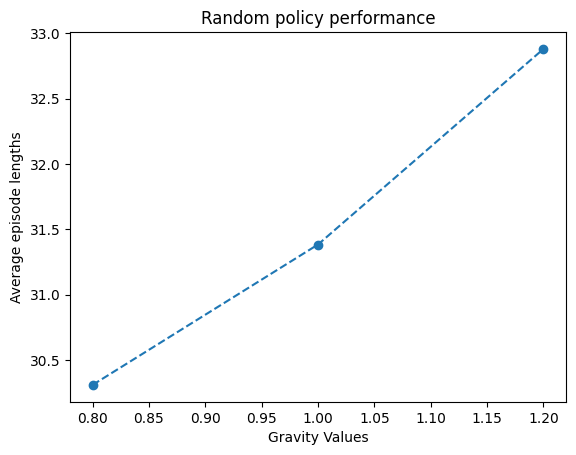

In [41]:
# TODO:
# - Test random policy under gravity × {0.8, 1.0, 1.2}
# - Store average episode length
# - Plot results

average_episode_lengths = []
G = [0.8,1.0,1.2]

for g in G:
    env = FlappyEnv(g)
    print("Gravity ==",g)
    average_length = run_random_policy(env)
    average_episode_lengths.append(average_length)

plt.plot(G,average_episode_lengths,marker='o',linestyle='--')
plt.xlabel('Gravity Values')
plt.ylabel('Average episode lengths')
plt.title('Random policy performance')
plt.show()

## Submission Checklist
- All TODOs implemented
- No RL training code
- Environment deterministic
- Random policy runs without crashing
- Stress test plot included